In [2]:
import cartopy 
import glob
import matplotlib.pyplot as plt
import os
import xarray as xr
import xgcm 
from fastjmd95 import jmd95numba 
import numpy as np


BASE = '/scratch/ab10313/pleiades/'

PATH_LIST_PP = glob.glob(BASE+'*_smooth/preprcossed_data/')


In [3]:
PATH_LIST_PP

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [13]:
ds_T_surf = xr.open_dataset(BASE+'global/ds_T_surf.nc',engine='h5netcdf')
ds_S_surf = xr.open_dataset(BASE+'global/ds_S_surf.nc',engine='h5netcdf')

#coarsen resolution to 1/4 degree
ds_surf =xr.merge([ds_T_surf.coarsen(i=12,j=12, boundary="trim").mean(),
                   ds_S_surf.coarsen(i=12,j=12, boundary="trim").mean()])

grid_surf = xgcm.Grid(ds_surf)



In [14]:
# sigma from temp and salt, using the fastjmd95 package

    
# reference density 
rho0 = 1000 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0_surf = jmd95numba.rho(ds_surf.Salt.chunk(chunks={'j': ds_surf.j.size, 'i': ds_surf.i.size}),
                         ds_surf.Theta.chunk(chunks={'j': ds_surf.j.size, 'i': ds_surf.i.size}), 0) - rho0

sigma0_surf = sigma0_surf.rename('sigma0')


# gravity
G = 9.81 #m/s^2

# buoyancy
B_surf = -G*sigma0_surf/rho0
B_surf = B_surf.rename('Buoyancy')


# horizontal x buoyancy gradient
B_surf_x = B_surf.diff(dim='i')/B_surf.dxF

# horizontal y buoyancy gradient
B_surf_y = B_surf.diff(dim='j')/B_surf.dyF

grad_B_surf_plot = np.sqrt(B_surf_y**2 + B_surf_x**2)

In [5]:
def lonlat_minmax(var_name_string):
    PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/'+var_name_string+'.nc') 
    data_min = np.zeros(len(PATH_LIST))
    data_max = np.zeros(len(PATH_LIST))
    for i_file in np.arange(0,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH)
        data_min[i_file] = np.round(data.min().values)
        data_max[i_file] = np.round(data.max().values)   
    return data_min, data_max

In [6]:
lat_min_data, lat_max_data = lonlat_minmax('lat')
lon_min_data, lon_max_data= lonlat_minmax('lon')

In [9]:
PATH_LIST_PP

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [7]:
lat_min_data

array([  0., -55., -60.,  10.,  -8.,  30., -30., -50., -55., -25.])

In [8]:
lat_max_data

array([  9., -49., -55.,  19.,   1.,  38., -22., -44., -49., -16.])

In [10]:
lon_min_data

array([  55.,  -57., -175., -179.,  -29.,  -57.,  -25.,  -33., -125.,
         71.])

In [11]:
lon_max_data

array([  65.,  -47., -165., -169.,  -19.,  -47.,  -15.,  -23., -115.,
         81.])

In [17]:
lon_min = [-60, -25, -30, -60, -140, -140, 145,-180, -175, 20, 70, 55]
lon_max = [-45, -10, -15, -45, -125, -125, 160,-165, -160, 35, 85, 70]

lat_min = [30, -30, -8 , -55, 30, -45, 25, 10, -60, -55, -25, 0]
lat_max = [45, -15, 8, -40, 45, -30, 40, 25, -45, -40, -10, 15]

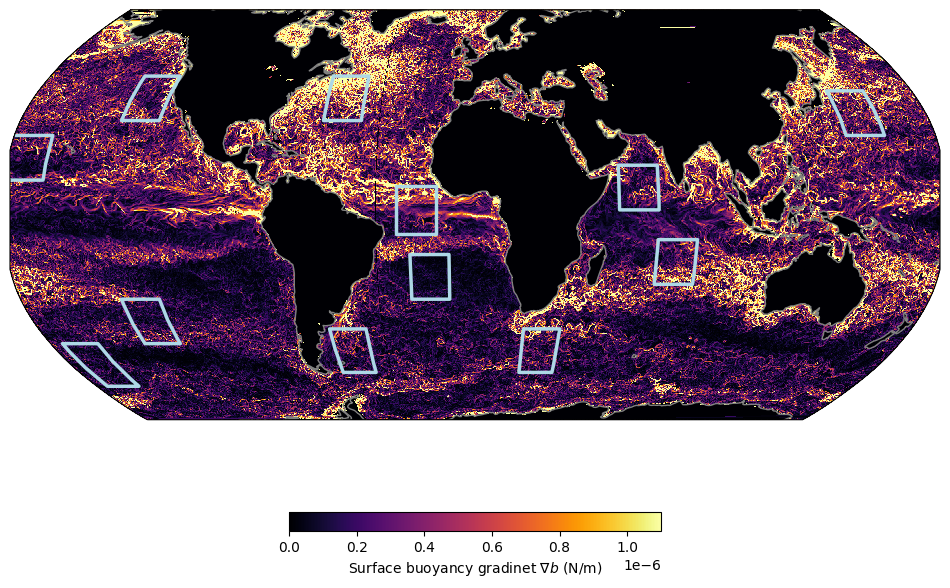

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from shapely.geometry.polygon import LinearRing
import cartopy.feature as cfeature



PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/')

subplot_kws=dict(projection=ccrs.Robinson(),facecolor='black')

plt.figure(figsize=[12,8])


p = grad_B_surf_plot.fillna(0).plot(x='XC', y='YC',
                  vmin=0, vmax=1.1e-6,
                  cmap='inferno',
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

#p.axes.set_extent((-180, 180, -90, 90))
p.axes.coastlines(color='gray')
p.axes.stock_img()
p.axes.set_extent([-180, 180, -73, 69], crs=ccrs.PlateCarree())
for i_box in np.arange(12):#len(lat_max)):
    lons = [lon_min[i_box], lon_min[i_box], lon_max[i_box], lon_max[i_box]]
    lats = [lat_min[i_box], lat_max[i_box], lat_max[i_box], lat_min[i_box]]
    ring = LinearRing(list(zip(lons, lats)))
    p.axes.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='lightblue', linewidth=2.5)
    
# add separate colorbar
cb = plt.colorbar(p, shrink=0.4,location='bottom')
cb.ax.tick_params(labelsize=10)
cb.set_label('Surface buoyancy gradinet ' +r'$\nabla b$' + ' (N/m)')

#plt.savefig('./figures/surf_grad_b')
# background
#url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
#p.axes.add_wmts(url, 'BlueMarble_NextGeneration')